# Linear Regression

In [79]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import trange

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Linear Regression from Scratch

In [80]:
# Random seed set up
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Data Import

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>],
       [<Axes: title={'center': 'wine_type'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

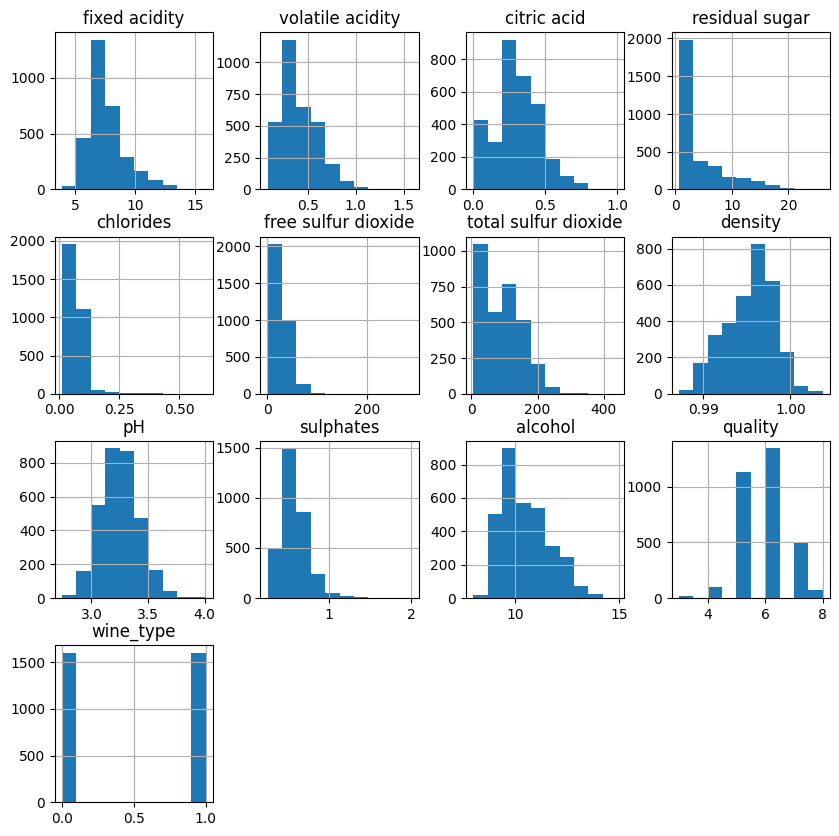

In [81]:
# Data import and visualization
data_red = pd.read_csv("data/winequality-red-new.csv")
data_white = pd.read_csv("data/winequality-white-new.csv")

data_red["wine_type"] = 1
data_white["wine_type"] = 0

data = pd.concat([data_red, data_white], axis=0)

data.hist(figsize=(10, 10))

### Data Preprocessing

#### Remove Outliers

In [ ]:
def remove_outliers(data, features):
    '''
    Removes outliers within a given interquartile range.
    
    Args:
        data: (Dataframe) Data to be processed
        features: (list) Features where outliers will be removed

    Returns:
        data: (dataframe) Data with outliers removed
    
    '''
    
    for feature in features:
        
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)

        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR

        data = data.loc[(data[feature] > low) & (data[feature] < high)]

    return data

data = data.dropna()
data = remove_outliers(data, ['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'residual sugar'])

#### Normalization

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>],
       [<Axes: title={'center': 'wine_type'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

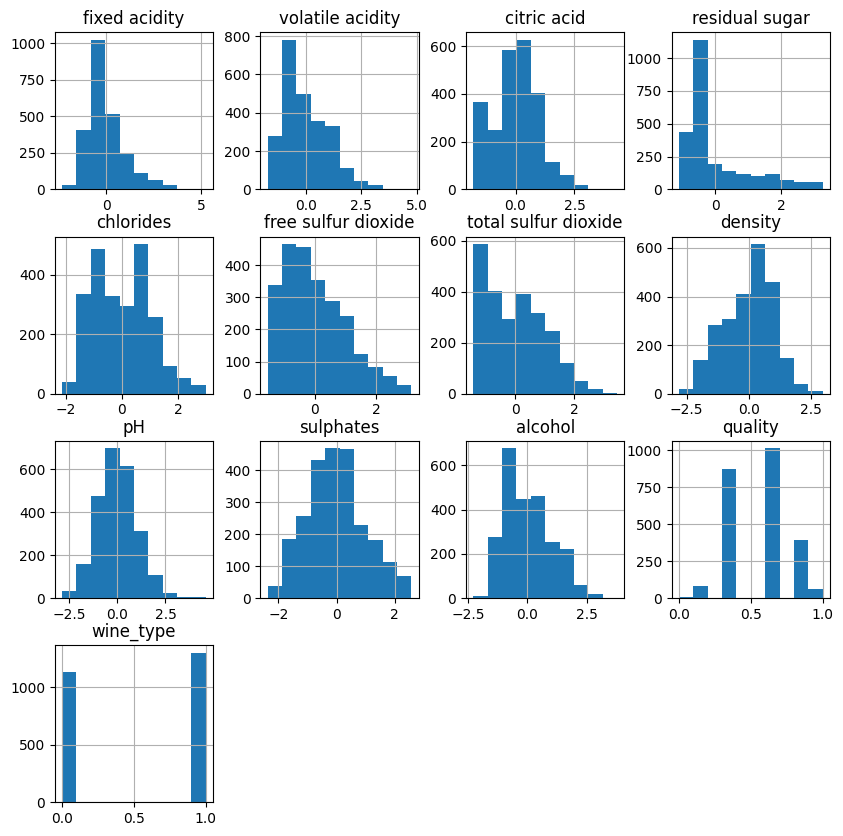

In [86]:
def normalize_data(data, regression_targets, classification_targets):
    '''
    Scales features using z-score normalization
    
    Args:
        data: (Dataframe) Data that will be normalized.
        regression_targets: (list) Linear regression targets. Will be scaled to the range [0, 1]
        classification_targets: (list) Linear classification targets. Will not be normalized, assuming it is categorical data.
        
    Returns:
        normalized: (Dataframe) Data that is normalized
    '''
    
    normalized = pd.DataFrame()
    
    for column in data:
        if column in regression_targets:
            scaler = MinMaxScaler()
            normalized[column] = scaler.fit_transform(data[[column]])
        elif column in classification_targets:
            normalized[column] = data[column]
        else:
            normalized[column] = (data[column] - data[column].mean()) / data[column].std()
    
    return normalized

data_normalized = normalize_data(data, ['quality'], ['wine_type'])
 
assert np.isclose(data_normalized.drop(columns=["quality", "wine_type"]).mean(axis=0), 0).all()
assert np.isclose(data_normalized.drop(columns=["quality", "wine_type"]).std(axis=0), 1).all()
assert data_normalized["wine_type"].apply(lambda x: x in [0, 1]).all()
assert data_normalized["quality"].apply(lambda x: 0 <= x and x <= 1).all()

data_normalized.hist(figsize=(10, 10))

### Dataset Preparation

In [20]:
def test_split(data, test_ratio=0.2, seed=SEED):
    x_data = data.drop(['quality', 'wine_type'], axis=1)
    y_data = data[["quality", "wine_type"]]
    x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=test_ratio, random_state=seed)
    
    return (x_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            x_test.reset_index(drop=True),
            y_test.reset_index(drop=True))
    
def train_val_split(x_train_val, y_train_val, k=5):
    index_shuffle = list(x_train_val.index)
    random.shuffle(index_shuffle)
    
    val_indices_list = []
    
    for fold_i in range(k):
        
        fold_idx = []
        for i in range(0, len(index_shuffle), k):
            if i + fold_i < len(index_shuffle):
                fold_idx.append(index_shuffle[i + fold_i])
                
        val_indices_list.append(fold_idx)
        
    train_val_list = []
    
    for fold in val_indices_list:
        x_traink = x_train_val.drop(fold)
        y_traink = y_train_val.drop(fold)
        x_valk = x_train_val.iloc[fold]
        y_valk = y_train_val.iloc[fold]
        train_val_list.append((x_traink, y_traink, x_valk, y_valk))
    
    return train_val_list

In [21]:
K = 5
x_train_val, y_train_val, x_test, y_test = test_split(data_normalized, test_ratio=0.2)
train_val_list = train_val_split(x_train_val, y_train_val)

### Training

In [22]:
def mean_square_error_loss(pred: np.ndarray, target: np.ndarray):
    return np.sum(np.square(pred-target)) / pred.shape[0]

def mse_gradient(X: np.ndarray, target: np.ndarray, theta: np.ndarray):
    predictions = np.dot(X, theta)
    return X.T.dot(predictions - target)

In [23]:
epochs = 100000
lr = 0.0000001

In [ ]:
train_losses_folds = [[] for _ in range(K)]
val_losses_folds = [[] for _ in range(K)]

thetas = []

In [25]:
for i in range(K):
    x_train, y_train, x_val, y_val = train_val_list[i]
    
    y_train = y_train["quality"]
    y_val = y_val["quality"]
    
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    y_train = y_train.to_numpy() 
    y_val = y_val.to_numpy()
    
    theta = np.append(np.ones(x_train.shape[1]), 1)
    x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
    x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
    
    for epoch in trange(epochs, desc=f"Epoch"):
        train_losses_folds[i].append(mean_square_error_loss(x_train @ theta, y_train))
        val_losses_folds[i].append(mean_square_error_loss(x_val @ theta, y_val))
        
        theta = theta - (lr * mse_gradient(x_train, y_train, theta))
        
    thetas.append(theta)

Epoch: 100%|██████████| 100000/100000 [00:02<00:00, 33800.46it/s]


Averaged final training loss: 0.018746369126618707
Averaged final validation loss: 0.019000732505098726


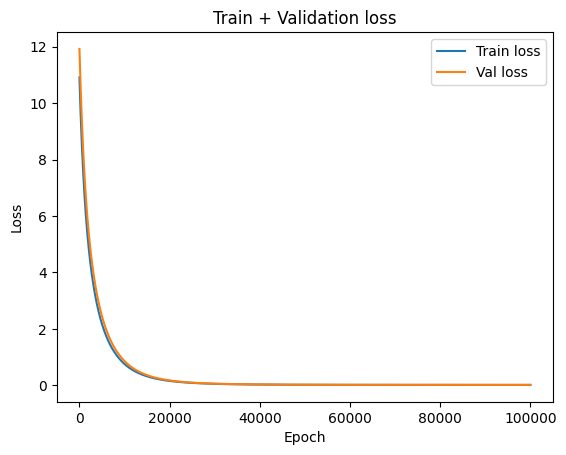

In [32]:
print(f"Averaged final training loss: {sum([train_losses[-1] for train_losses in train_losses_folds]) / len(train_losses_folds)}")
print(f"Averaged final validation loss: {sum([val_losses[-1] for val_losses in val_losses_folds]) / len(val_losses_folds)}")

plt.plot(np.arange(epochs), train_losses_folds[0], label="Train loss")
plt.plot(np.arange(epochs), val_losses_folds[0], label="Val loss")
plt.title("Train + Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Result

In [48]:
def inference(x_test, thetas):
    x_test_with_bias = np.hstack([x_test, np.ones((x_test.shape[0], 1))])
    return x_test_with_bias @ thetas[-1]
    
test_pred = inference(x_test, thetas)
print(f"Model Loss: {mean_square_error_loss(test_pred, y_test["quality"])}")

Model Loss: 0.01988348561165829


## Linear Regression with Scikit-learn

In [45]:
model = linear_model.LinearRegression()
model.fit(x_train_val, y_train_val)
y_pred = model.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 0.02
